In [1]:
import os
import pickle
import random

In [2]:
os.chdir('yelp_academic')

In [5]:
pickle_old = 'comparison/ambience_lr_densenet_transfer_mispredicted.pickle'
pickle_new = 'comparison/ambience_lr_combined_binary_mispredicted.pickle'

In [6]:
with open(pickle_old, 'rb') as po:
    old_mispred = pickle.load(po)

In [7]:
with open(pickle_new, 'rb') as pn:
    new_mispred = pickle.load(pn)

In [8]:
mispred_filenames = [m['filename'] for m in new_mispred]

In [9]:
correctly_predicted = [pred for pred in old_mispred if pred['filename'] not in mispred_filenames]

In [10]:
correctly_predicted
len(correctly_predicted)

119

In [11]:
experiment_subsample = random.sample(correctly_predicted, 10)

In [12]:
experiment_subsample

[{'filename': 'zY8jp9EMpaJl5DspVt64ng',
  'actual': array([0, 1, 0, 0, 0, 0]),
  'prediction': array([0, 1, 0, 0, 0, 1])},
 {'filename': '2nTcyggGDYSSNJ2IrJp4cg',
  'actual': array([0, 1, 0, 0, 0, 0]),
  'prediction': array([1, 1, 0, 0, 0, 0])},
 {'filename': 'FfaQplY6ldnN14mcehgukw',
  'actual': array([1, 0, 0, 0, 0, 0]),
  'prediction': array([1, 0, 0, 1, 0, 0])},
 {'filename': '9HutQYF_lIibPZpjvo6C3g',
  'actual': array([1, 0, 0, 0, 0, 0]),
  'prediction': array([1, 0, 1, 0, 0, 0])},
 {'filename': 'bkb8TGYGbBZ9AgpVjB-bEg',
  'actual': array([0, 1, 0, 0, 0, 0]),
  'prediction': array([0, 1, 1, 0, 0, 0])},
 {'filename': 'cQoZJKLIoUqB0VVif3tO7g',
  'actual': array([0, 1, 0, 0, 0, 0]),
  'prediction': array([1, 1, 0, 0, 0, 0])},
 {'filename': '4ZeWVz5sEIa5D_Q9aH7LSA',
  'actual': array([0, 1, 0, 0, 0, 0]),
  'prediction': array([0, 0, 0, 0, 0, 1])},
 {'filename': 'bMnvuiS7ar9YXJ0Lh-d4cw',
  'actual': array([0, 1, 0, 0, 0, 0]),
  'prediction': array([1, 1, 0, 0, 0, 0])},
 {'filename': '5

## TV test

In [13]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont
import cv2

import numpy as np
import colorsys
import random

In [14]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [15]:
detection_model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(
    pretrained=True, progress=True, num_classes=91, pretrained_backbone=True, trainable_backbone_layers=None)

In [16]:
detection_model.eval()
1

1

In [95]:
def get_prediction(model, image, threshold):
    
    transform = transforms.Compose([transforms.ToTensor()])
    img = transform(image)
    
    preds = model([img])[0]
    
    keep_boxes = torchvision.ops.nms(preds['boxes'], preds['scores'], 0.5)
    
    classes = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(preds['labels'].numpy())]
    classes = [classes[idx] for idx in keep_boxes]
    boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(preds['boxes'].detach().numpy())]
    boxes = [boxes[idx] for idx in keep_boxes]
    scores = list(preds['scores'].detach().numpy())
    scores = [scores[idx] for idx in keep_boxes]
    
    valid_boxes = [scores.index(x) for x in scores if x>threshold]
    if not valid_boxes: return [()]
    p_thresh = valid_boxes[-1]
    pred_boxes = boxes[:p_thresh+1]
    pred_classes = classes[:p_thresh+1]
    pred_scores = scores[:p_thresh+1]
    
    return list(zip(pred_boxes, pred_classes, pred_scores))

In [126]:
def draw_boxes(model, img_path, font_color='white', threshold=0.5):
    img = Image.open(img_path)
    draw = ImageDraw.Draw(img)
    predictions = get_prediction(model, img, threshold)
    for i in range(len(predictions)):
        box, label, score = predictions[i]
        draw.rectangle(box)
        x1,y1 = box[0]
        x2,y2 = box[1]
        x=(x1+x2)//2
        y=(y1+y2)//2
        draw.text((x,y), label, fill=font_color)
    return img

In [127]:
mapping = ['touristy', 'hipster', 'romantic', 'divey', 'intimate', 'upscale']

In [128]:
def return_subsample_element(subsample_item, text_color):
    fname = f"photos/{subsample_item['filename']}.jpg"
    img = draw_boxes(detection_model, fname, font_color=text_color)
    actual_decoded = []
    predicted_decoded = []
    for i in range(len(mapping)):
        if subsample_item['actual'][i]:
            actual_decoded.append(mapping[i])
        if subsample_item['prediction'][i]:
            predicted_decoded.append(mapping[i])
    return img, actual_decoded, predicted_decoded

In [278]:
img, actual, predicted = return_subsample_element(correctly_predicted[44], 'white')

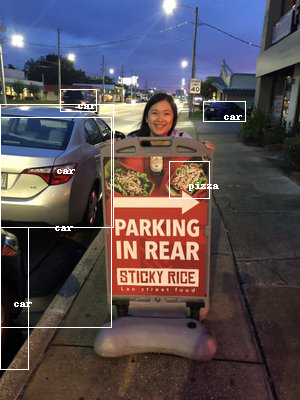

In [279]:
img

In [280]:
predicted, actual

(['touristy', 'hipster', 'divey'], ['hipster', 'divey'])